### What The lady asked
- benchmark: K-means
- innitialization: random vs k-means
- modalities: T1-w vs T1-w+FLAIR
- metrics: DSC, num iterations, comp.time

In [20]:
import utils
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import SimpleITK as sitk
from pathlib import Path
from sklearn.cluster import KMeans
from src import ExpectationMaximization

In [30]:
def brain_tissue_segmentation(t1, t2, brain_mask, mode):
    # T1+T2
    t1_vector = t1[brain_mask == 255].flatten()
    t2_vector = t2[brain_mask == 255].flatten()
    data = np.array([t1_vector, t2_vector]).T
    if mode == 'em':
        model = ExpectationMaximization(
            n_components=3, mean_init='kmeans',
            priors='non_informative', verbose=False, plot_rate=None,
            hard_em=True, use_our_gauss_likelihood=False)
    else:
        model = KMeans(n_clusters=3, random_state=420)
    start = time.time()
    preds = model.fit_predict(data)
    t_t1_t2 = time.time() - start
    predictions = brain_mask.flatten()
    predictions[predictions==255] = preds + 1
    t1_t2_seg_res = predictions.reshape(t1.shape)
    # T1
    data = np.array(t1_vector)[:, np.newaxis]
    if mode == 'em':
        model = ExpectationMaximization(
            n_components=3, mean_init='kmeans',
            priors='non_informative', verbose=False, plot_rate=None,
            hard_em=True, use_our_gauss_likelihood=False)
    else:
        model = KMeans(n_clusters=3, random_state=420)
    start = time.time()
    preds = model.fit_predict(data)
    t_t1 = time.time() - start
    predictions = brain_mask.flatten()
    predictions[predictions==255] = preds + 1
    t1_seg_res = predictions.reshape(t1.shape)
    return t1_seg_res, t1_t2_seg_res, t_t1, t_t1_t2


def dice_score(gt, pred):
    classes = np.unique(gt[gt != 0])
    dice = np.zeros((len(classes)))
    for i in classes:
        bin_pred = np.where(pred == i, 1, 0)
        bin_gt = np.where(gt == i, 1, 0)
        dice[i-1] = np.sum(pred[bin_gt == 1]) * 2.0 / (np.sum(pred) + np.sum(gt))
    return dice.tolist()


def plots(t1_array, t2_array,  t1_seg_res_em, t1_seg_res_km, t1_t2_seg_res_em, t1_t2_seg_res_km, gt, slice_n = 20):
    plt.figure(figsize=(20, 5))
    plt.subplot(171)
    plt.title('T1')
    plt.imshow(t1_array[slice_n, :, :], cmap='gray')
    plt.axis('off')
    plt.subplot(172)
    plt.title('T2')
    plt.imshow(t2_array[slice_n, :, :], cmap='gray')
    plt.axis('off')
    
    plt.subplot(173)
    plt.title('EM T1')
    plt.imshow(t1_seg_res_em[slice_n, :, :])
    plt.axis('off')
    plt.subplot(174)
    plt.title('KMeans T1')
    plt.imshow(t1_seg_res_km[slice_n, :, :])
    plt.axis('off')
    plt.subplot(175)
    plt.title('EM T1+T2')
    plt.imshow(t1_t2_seg_res_em[slice_n, :, :])
    plt.axis('off')
    plt.subplot(176)
    plt.title('KMeans T1+T2')
    plt.imshow(t1_t2_seg_res_km[slice_n, :, :])
    plt.axis('off')
    
    plt.subplot(177)
    plt.title('GT')
    plt.imshow(gt[slice_n, :, :])
    plt.axis('off')
    plt.show()

-------------------- Subject N°0 --------------------


  9%|▉         | 9/100 [00:01<00:16,  5.69it/s]


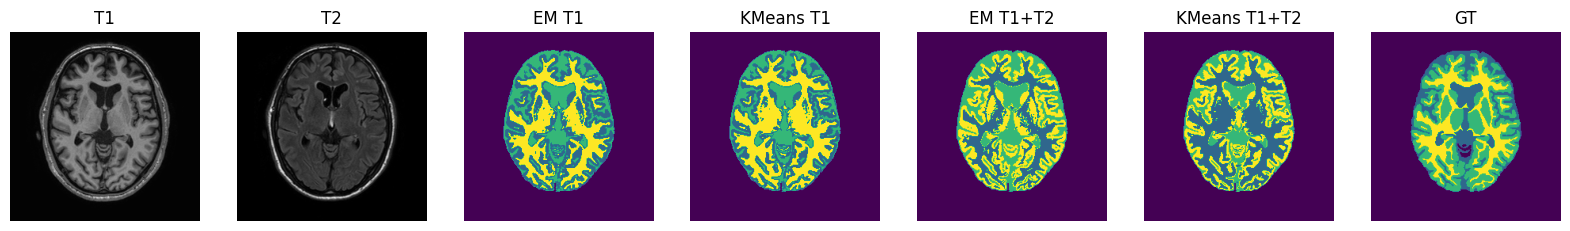

-------------------- Subject N°1 --------------------


  4%|▍         | 4/100 [00:00<00:18,  5.07it/s]


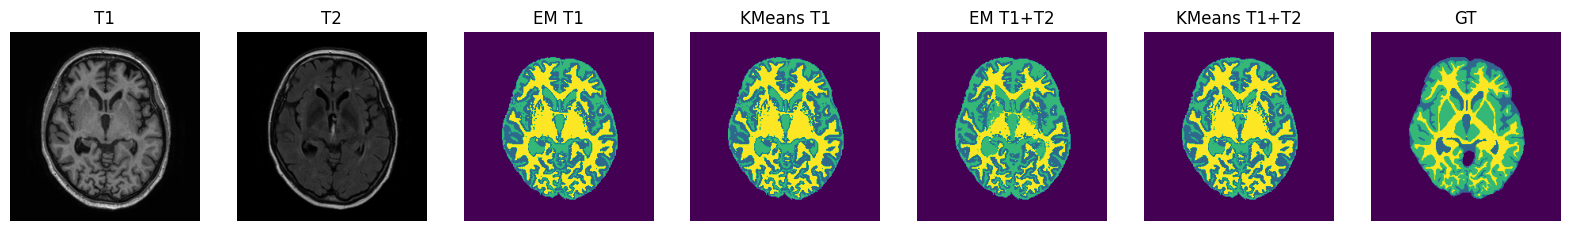

-------------------- Subject N°2 --------------------


 12%|█▏        | 12/100 [00:02<00:14,  5.96it/s]


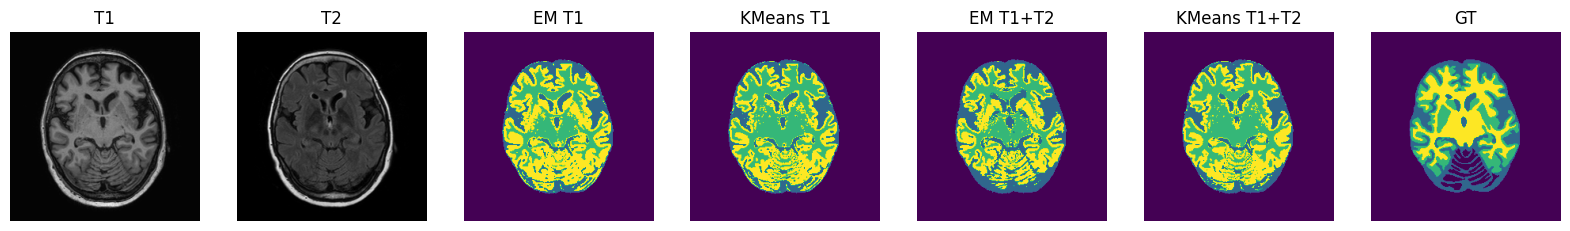

-------------------- Subject N°3 --------------------


 11%|█         | 11/100 [00:01<00:14,  6.18it/s]


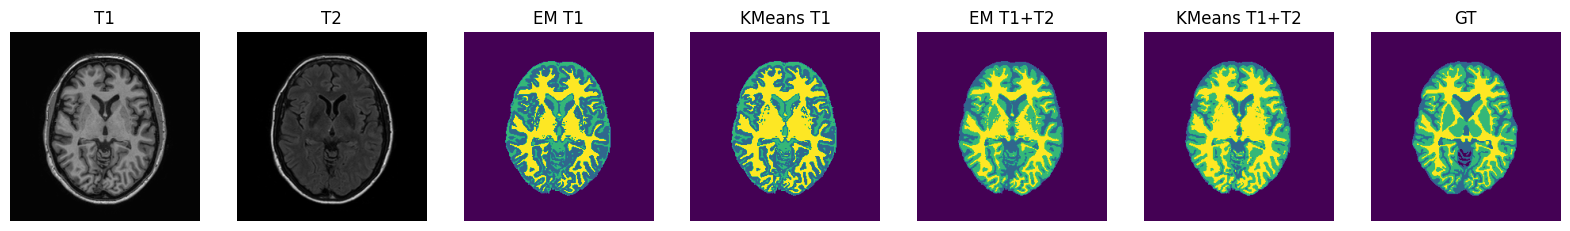

-------------------- Subject N°4 --------------------


 11%|█         | 11/100 [00:01<00:15,  5.75it/s]


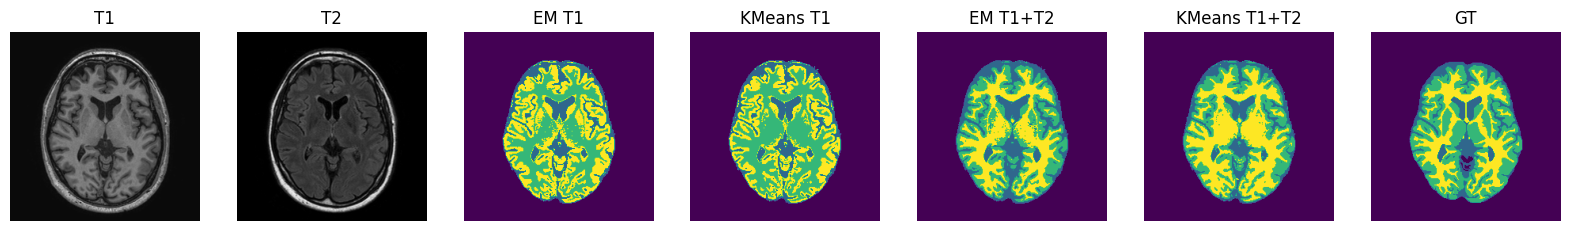

,CSF,GM,WM,modalities,subject,model,time
0,0.294809,0.269044,0.382053,t1,0,km,0.768769
1,0.369938,0.418281,0.137322,t1_t2,0,km,2.427306
2,0.305483,0.237898,0.381248,t1,0,em,2.607861
3,0.329600,0.464161,0.159706,t1_t2,0,em,9.678755
4,0.258774,0.322558,0.340121,t1,1,km,0.748426
5,0.256030,0.326466,0.340775,t1_t2,1,km,2.126652
6,0.261436,0.316762,0.339812,t1,1,em,1.677676
7,0.279125,0.297557,0.328776,t1_t2,1,em,14.635155
8,0.209738,0.441137,0.284295,t1,2,km,0.663365
9,0.221257,0.436902,0.281802,t1_t2,2,km,2.024044


In [31]:
data_path = Path.cwd().parent / 'data/P2_data'

dice_scores = []
for i in range(5):
    print(f'{"-"*20} Subject N°{i} {"-"*20}')
    t1 = sitk.ReadImage(data_path / f'{i+1}/T1.nii')
    t2 = sitk.ReadImage(data_path / f'{i+1}/T2_FLAIR.nii')
    gt = sitk.ReadImage(data_path / f'{i+1}/LabelsForTesting.nii')
    bm = sitk.ReadImage(data_path / f'{i+1}/brain_mask.nii')

    t1_array = sitk.GetArrayFromImage(t1)
    t2_array = sitk.GetArrayFromImage(t2)
    gt_array = sitk.GetArrayFromImage(gt)
    bm = sitk.GetArrayFromImage(bm)

    t1_array = utils.min_max_norm(t1_array, 255, 'uint8')
    t2_array = utils.min_max_norm(t2_array, 255, 'uint8')

    t1_seg_res_em, t1_t2_seg_res_em, t_t1_em, t_t1_t2_em = brain_tissue_segmentation(t1_array, t2_array, bm, 'em')
    t1_seg_res_km, t1_t2_seg_res_km, t_t1_km, t_t1_t2_km = brain_tissue_segmentation(t1_array, t2_array, bm, 'km')

    # TODO: Fix matching between labels, maybe checking the mean intensity in each label in the ground truth
    #    and assigning it to the class with the closest label in the prediction
    dice_scores.append(dice_score(gt_array, t1_seg_res_km) + ['t1', i, 'km', t_t1_km])
    dice_scores.append(dice_score(gt_array, t1_t2_seg_res_km) + ['t1_t2', i, 'km', t_t1_t2_km])
    dice_scores.append(dice_score(gt_array, t1_seg_res_em) + ['t1', i, 'em', t_t1_em])
    dice_scores.append(dice_score(gt_array, t1_t2_seg_res_em) + ['t1_t2', i, 'em', t_t1_t2_em])
    
    plots(t1_array, t2_array, t1_seg_res_em, t1_seg_res_km, t1_t2_seg_res_em, t1_t2_seg_res_km, gt_array, slice_n = 20)
        
dice_scores = pd.DataFrame(data=dice_scores, columns = ['CSF', 'GM', 'WM', 'modalities', 'subject', 'model', 'time'])
dice_scores.to_csv('dice_scores.csv')
dice_scores